In [1]:
%matplotlib inline

#Enable reloading because restarting the kernel is a pain
%load_ext autoreload
%autoreload 2

import shapely
from shapely.geometry import Polygon, Point

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import numpy as np

from bot_2d_rep import *
from bot_2d_problem import *

import copy

from jupyter_dash import JupyterDash
from dash import html, dcc, Input, Output
import plotly.graph_objects as go
import pandas as pd

from tqdm.notebook import trange, tqdm

In [2]:
import datetime

timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
bot_name = "ToyBot"

# Set up & run the simple MOO problem

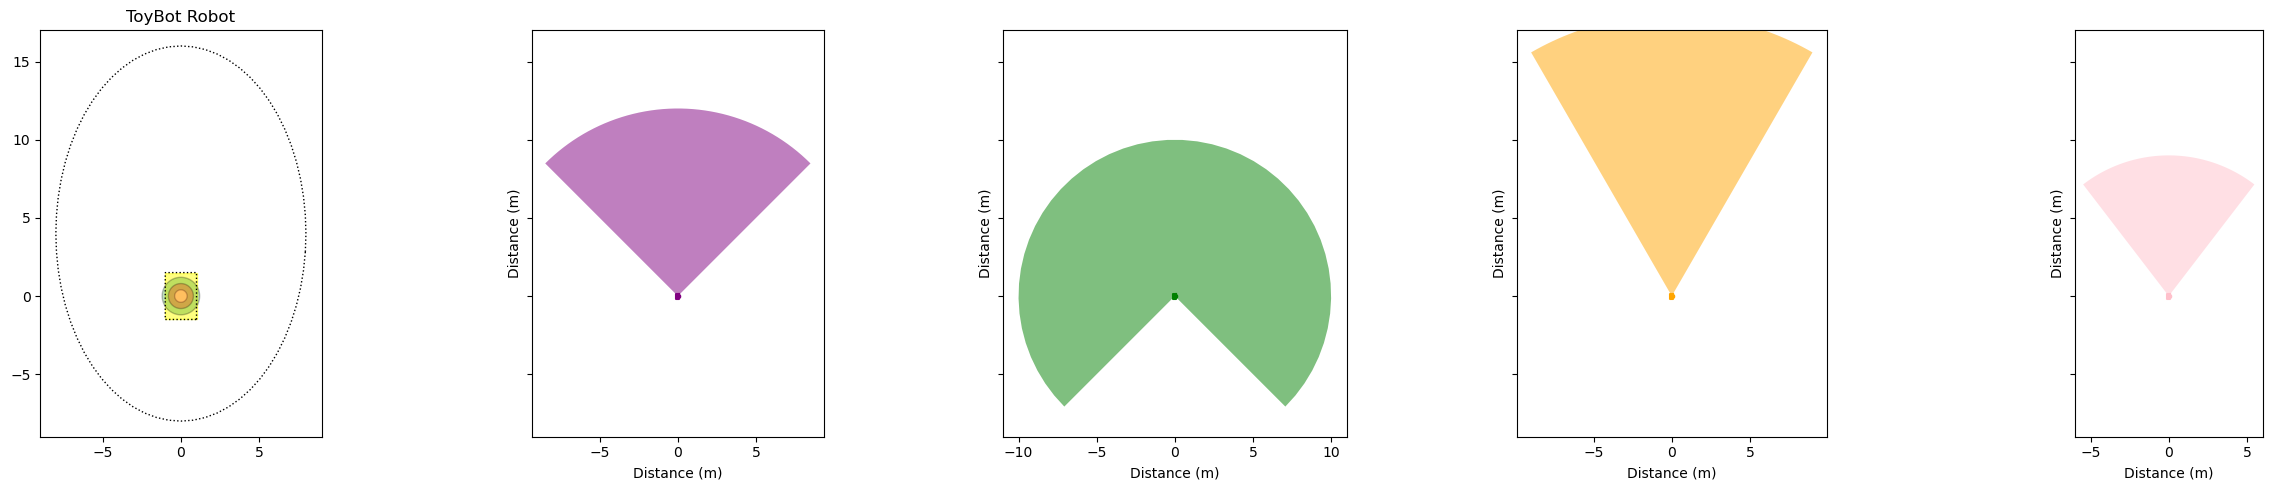

In [3]:
sensor_bounds = Polygon([(.1,.1), (-.1,.1),(-.1,-.2),(.1,-.2)])

sensor_options = [FOV2D_Simple(hfov=90, distance=12, cost=600.00, color="purple", bounds_polygon=copy.deepcopy(sensor_bounds)),
                  FOV2D_Simple(hfov=270, distance=10, cost=1200.00, color="green", bounds_polygon=copy.deepcopy(sensor_bounds)),
                  FOV2D_Simple(hfov=60, distance=18, cost=700.00, color="orange", bounds_polygon=copy.deepcopy(sensor_bounds)),
                  FOV2D_Simple(hfov=75, distance=9, cost=300.00, color="pink", bounds_polygon=copy.deepcopy(sensor_bounds))]

bot_diam = 1
bot_bounds = Polygon([(-1, -1.5), (-1, 1.5), (1, 1.5), (1, -1.5)])
sens_constraint = Polygon(Point(0, 0).buffer(bot_diam/1-.2).exterior.buffer(0.4))
occlusions = Polygon(Point(0, 0).buffer(bot_diam/1-.2))
sense_requirement =  Polygon(Point(0, 0).buffer(12).exterior.coords)
sense_requirement = shapely.affinity.scale(sense_requirement, xfact=2/3, yfact=1, origin=(0, 0))
sense_requirement = shapely.affinity.translate(sense_requirement, xoff=0, yoff=4)

spot = SimpleBot2d(bot_bounds, sense_requirement, sensor_pose_constraint=sens_constraint, bot_color="yellow", occlusions=occlusions)

num_plots=len(sensor_options)+1
fig, ax = plt.subplots(1, num_plots, sharey=True, figsize=(num_plots*5,5))

ax[0].set_title(f"{bot_name} Robot")
ax[0].set_aspect('equal')
spot.plot_bot(show_constraint=True, ax=ax[0])

for i, sensor in enumerate(sensor_options):
    sensor.plot_fov(ax=ax[i+1], whole_plot=True)
    ax[i+1].set_aspect('equal')
    ax[i+1].set_title(sensor.name)
    ax[i+1].sharey(ax[0])

fig.tight_layout()

fig.savefig(f"./_output/{bot_name.lower()}/{timestamp}_inputs.png")

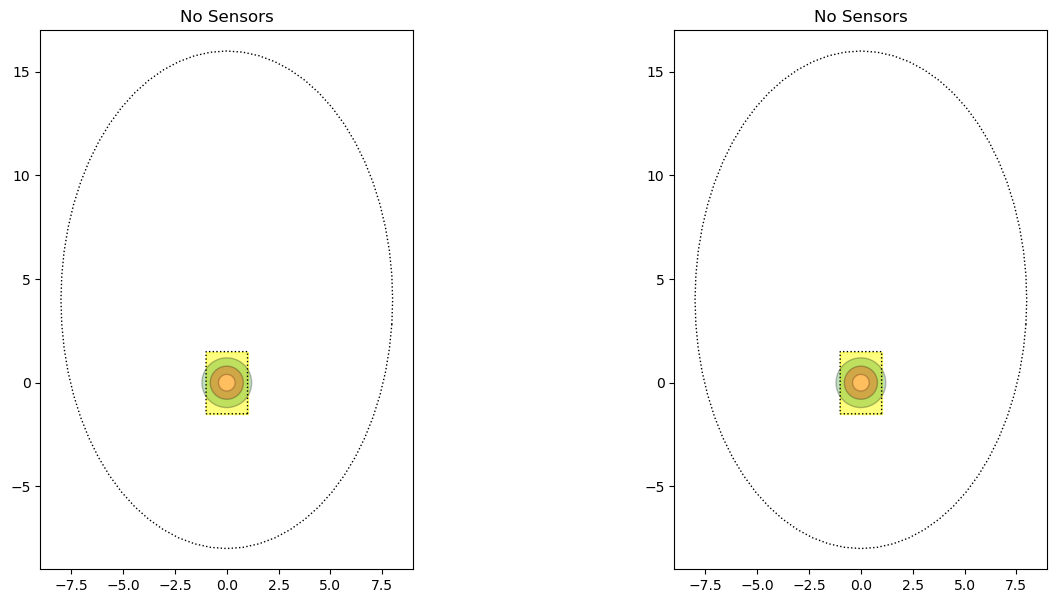

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

spot.plot_bot(show_constraint=True, title=f"No Sensors", ax=axes[0])
spot.plot_bot(show_constraint=True, title=f"No Sensors", ax=axes[1])

fig.savefig(f"./_output/{bot_name.lower()}/{timestamp}_botcompare_none.png")

In [ ]:
from pymoo.algorithms.moo.nsga2 import NSGA2, RankAndCrowdingSurvival
from pymoo.core.mixed import MixedVariableGA
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
import dill

max_sensors = 9
p_no_sensor = 0.1

problem = SensorPkgOptimization(spot, sensor_options, max_sensors)

p_sensor_probs = [p_no_sensor] + [(1-p_no_sensor)/(len(sensor_options)-1)]*(len(sensor_options)-1)

print("Probabilities:", p_sensor_probs)
print("Sum to:", sum(p_sensor_probs))

algorithm = MixedVariableGA(
    pop_size=400,
    n_offsprings=150,
    sampling=CustomSensorPkgRandomSampling(p=p_sensor_probs),
    survival=RankAndCrowdingSurvival(),
    eliminate_duplicates=MixedVariableDuplicateElimination(),
)

with open(f'./_output/{bot_name.lower()}/{timestamp}_problem.pkl', 'wb') as f:
    dill.dump(problem, f)

Probabilities: [0.1, 0.225, 0.225, 0.225, 0.225]
Sum to: 1.0


In [6]:
plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.family'] = 'Arial' 

In [7]:
res = minimize(problem,
               algorithm,
               ('n_gen', 800),
               seed=1,
               verbose=True)

pareto_front = problem.pareto_front(use_cache=True, flatten=False)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      400 |  0.3787648331 |  0.0470733706
     2 |      550 |  0.3673926802 |  0.0470733706
     3 |      700 |  0.3556697710 |  0.0470733706
     4 |      850 |  0.3535366170 |  0.0470733706
     5 |     1000 |  0.3450917479 |  0.0470733706
     6 |     1150 |  0.3378528279 |  0.0470733706
     7 |     1300 |  0.3327357664 |  0.0470733706
     8 |     1450 |  0.3265133576 |  0.0470733706
     9 |     1600 |  0.3255043160 |  0.0470733706
    10 |     1750 |  0.3198600339 |  0.0470733706
    11 |     1900 |  0.3187021686 |  0.0470733706
    12 |     2050 |  0.3173836089 |  0.0470733706
    13 |     2200 |  0.3150245212 |  0.0470733706
    14 |     2350 |  0.3143602139 |  0.0470733706
    15 |     2500 |  0.3146828118 |  0.0470733706
    16 |     2650 |  0.3135566865 |  0.0470733706
    17 |     2800 |  0.3123131704 |  0.0470733706
    18 |     2950 |  0.3137836012 |  0.0470733706
    19 |     3100 |  0.3138973209 |  0.0470733706


In [8]:
import pandas as pd
import plotly.express as px

# Create a DataFrame from the results
df_results = pd.DataFrame(res.F, columns=['Perception Coverage', 'Cost'])
df_results['Perception Coverage'] = (1- df_results['Perception Coverage']) * 100
df_results['Index'] = df_results.index
df_results['Name'] = [f"Pkg Concept {i}" for i in df_results.index]
df_results['X'] = res.X
df_results['History'] = [None] * len(df_results)
df_results["Optimized"] = "Non-optimized"

## Calculate the (Unoptimized) Pareto Front

In [9]:
import numpy as np

# Example usage
ideal_point = np.array([0., 0.])  # Example ideal point
pareto_front, pareto_idx = get_pareto_front(df_results, x='Cost', y='Perception Coverage')
pareto_unoptimized_df = df_results.iloc[pareto_idx]

pareto_unoptimized_df

,Perception Coverage,Cost,Index,Name,X,History,Optimized
0,0.000000,0.0,0,Pkg Concept 0,"{'s0_type': 0, 's1_type': 0, 's2_type': 0, 's3...",None,Non-optimized
3,17.918824,300.0,3,Pkg Concept 3,"{'s0_type': 0, 's1_type': 0, 's2_type': 0, 's3...",None,Non-optimized
8,37.150625,600.0,8,Pkg Concept 8,"{'s0_type': 0, 's1_type': 1, 's2_type': 0, 's3...",None,Non-optimized
9,51.465877,900.0,9,Pkg Concept 9,"{'s0_type': 4, 's1_type': 0, 's2_type': 0, 's3...",None,Non-optimized
5,63.888510,1200.0,5,Pkg Concept 5,"{'s0_type': 4, 's1_type': 4, 's2_type': 0, 's3...",None,Non-optimized
6,69.875724,1500.0,6,Pkg Concept 6,"{'s0_type': 0, 's1_type': 4, 's2_type': 0, 's3...",None,Non-optimized
4,79.155313,1800.0,4,Pkg Concept 4,"{'s0_type': 2, 's1_type': 0, 's2_type': 0, 's3...",None,Non-optimized
12,88.582548,2100.0,12,Pkg Concept 12,"{'s0_type': 2, 's1_type': 4, 's2_type': 0, 's3...",None,Non-optimized
13,89.764601,2400.0,13,Pkg Concept 13,"{'s0_type': 2, 's1_type': 1, 's2_type': 0, 's3...",None,Non-optimized
7,94.295648,2500.0,7,Pkg Concept 7,"{'s0_type': 2, 's1_type': 1, 's2_type': 0, 's3...",None,Non-optimized


In [10]:
import datetime
df_results.to_pickle(f"./_output/{bot_name.lower()}/{timestamp}_df_unopt.pkl")

# Run the single-objective optimization

  0%|          | 0/11 [00:00<?, ?it/s]

No sensors to optimize! Skipping optimization step.


/var/folders/wc/xsxjcsy91wl6d95rczwlspg80000gn/T/ipykernel_41560/159430316.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)
/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)
/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differe

/var/folders/wc/xsxjcsy91wl6d95rczwlspg80000gn/T/ipykernel_41560/159430316.py:21: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the app

/var/folders/wc/xsxjcsy91wl6d95rczwlspg80000gn/T/ipykernel_41560/159430316.py:21: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the app

/var/folders/wc/xsxjcsy91wl6d95rczwlspg80000gn/T/ipykernel_41560/159430316.py:21: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the app

/var/folders/wc/xsxjcsy91wl6d95rczwlspg80000gn/T/ipykernel_41560/159430316.py:21: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the app

/var/folders/wc/xsxjcsy91wl6d95rczwlspg80000gn/T/ipykernel_41560/159430316.py:21: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the app

/var/folders/wc/xsxjcsy91wl6d95rczwlspg80000gn/T/ipykernel_41560/159430316.py:21: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the app

/var/folders/wc/xsxjcsy91wl6d95rczwlspg80000gn/T/ipykernel_41560/159430316.py:21: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the app

/var/folders/wc/xsxjcsy91wl6d95rczwlspg80000gn/T/ipykernel_41560/159430316.py:21: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the app

/var/folders/wc/xsxjcsy91wl6d95rczwlspg80000gn/T/ipykernel_41560/159430316.py:21: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the app

/var/folders/wc/xsxjcsy91wl6d95rczwlspg80000gn/T/ipykernel_41560/159430316.py:21: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



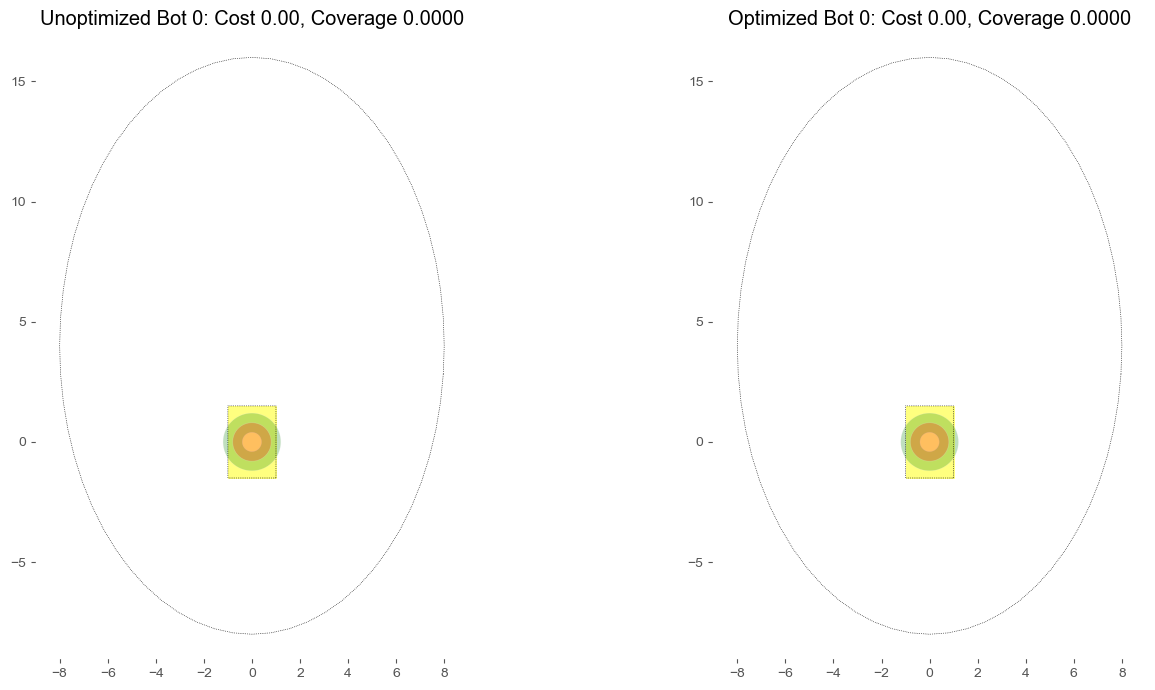

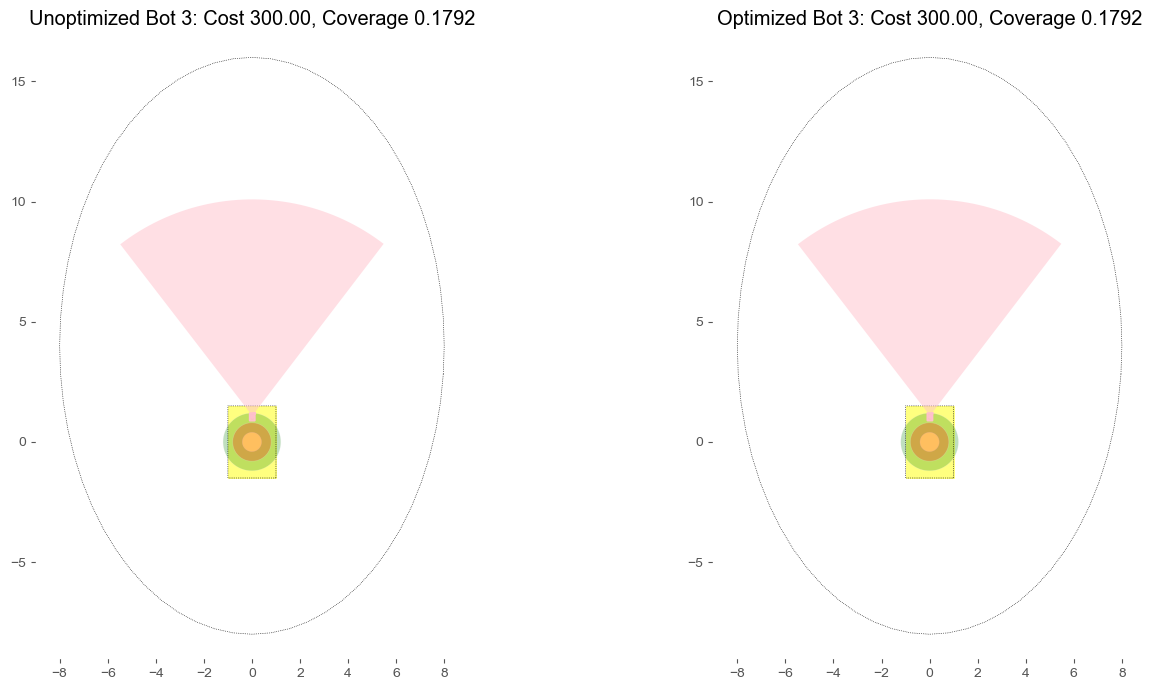

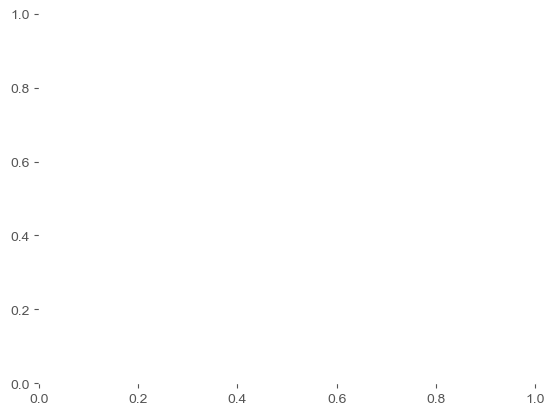

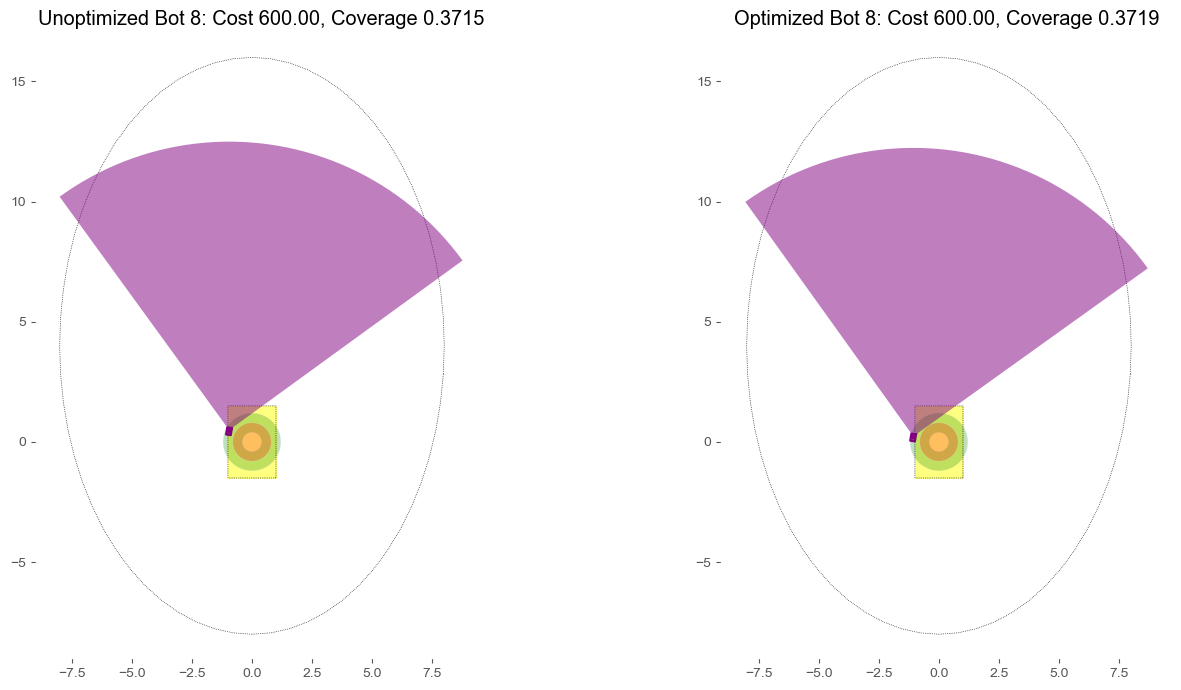

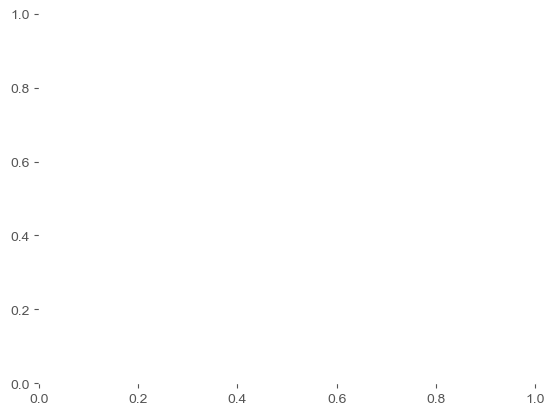

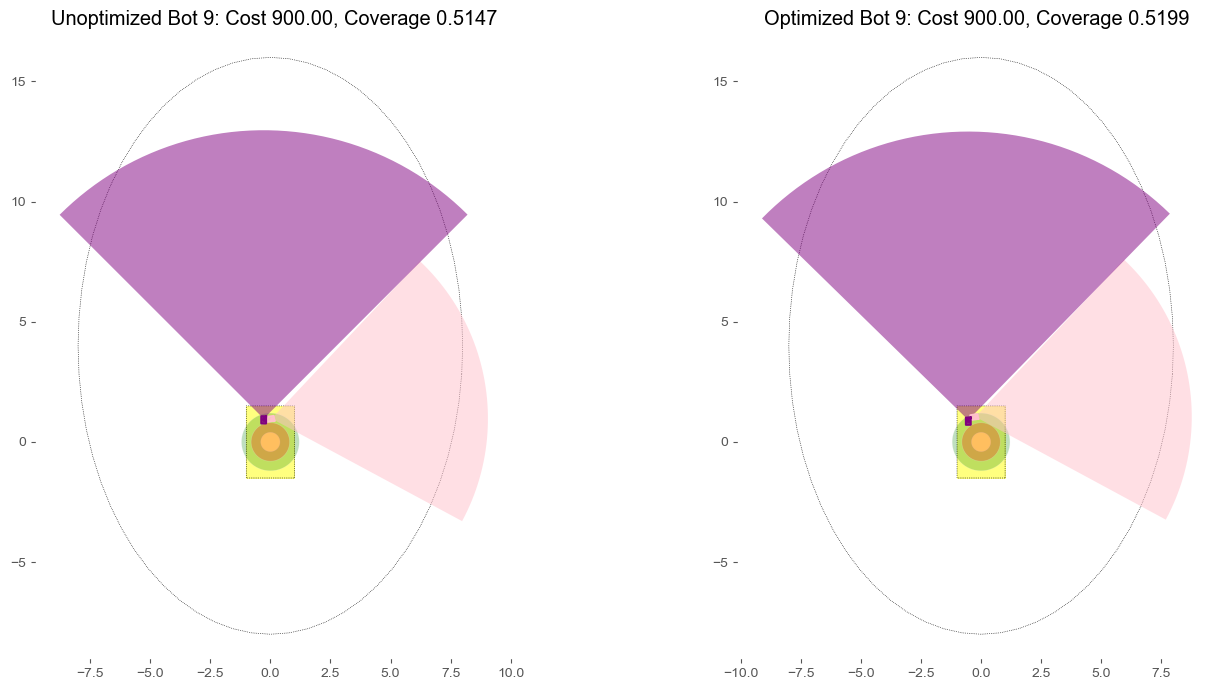

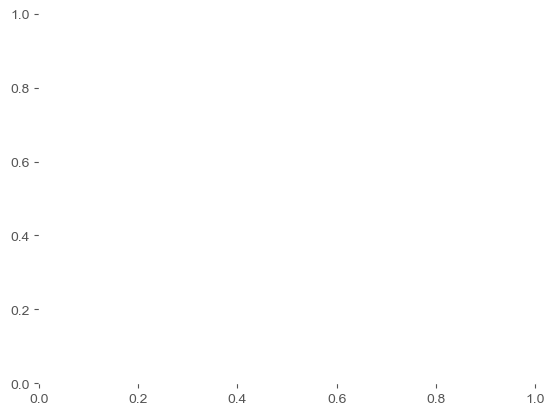

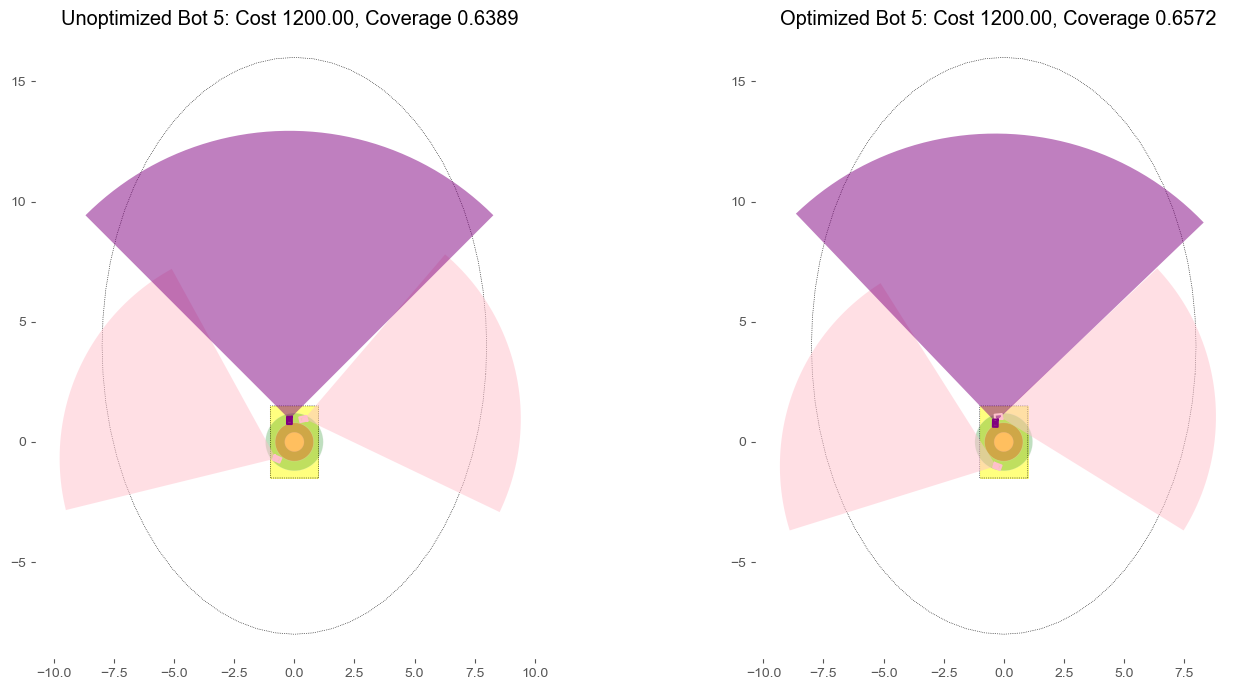

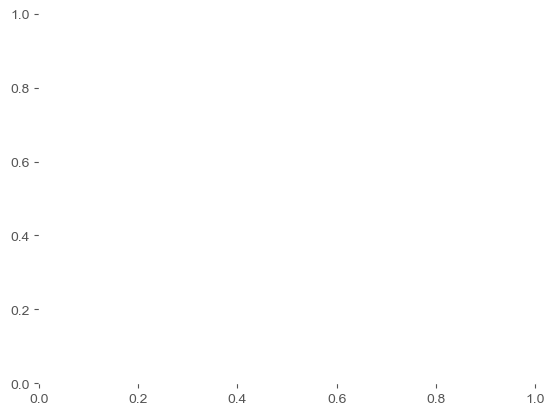

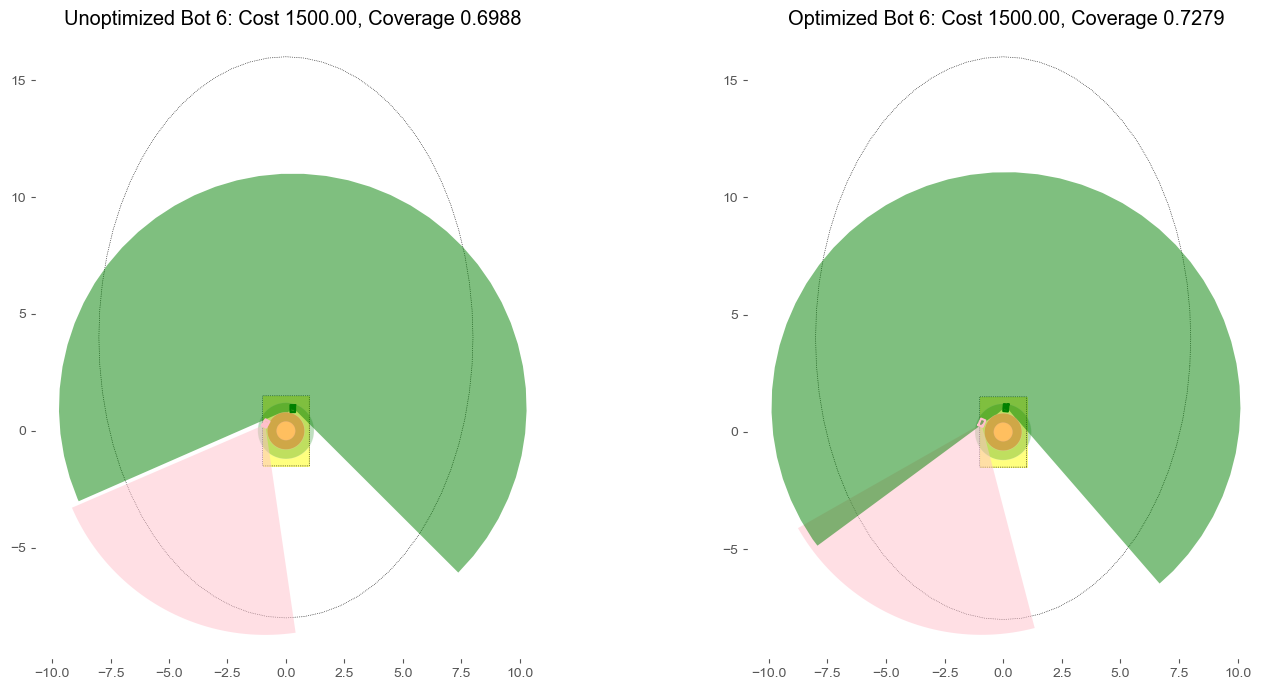

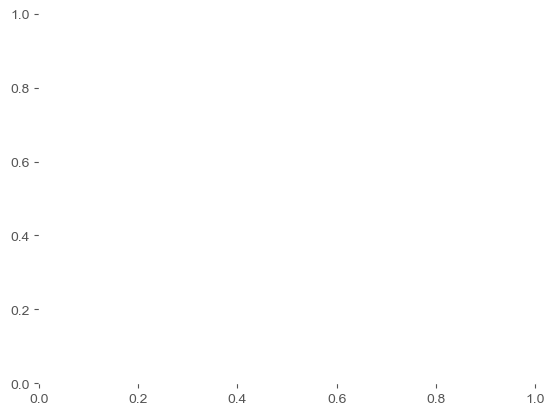

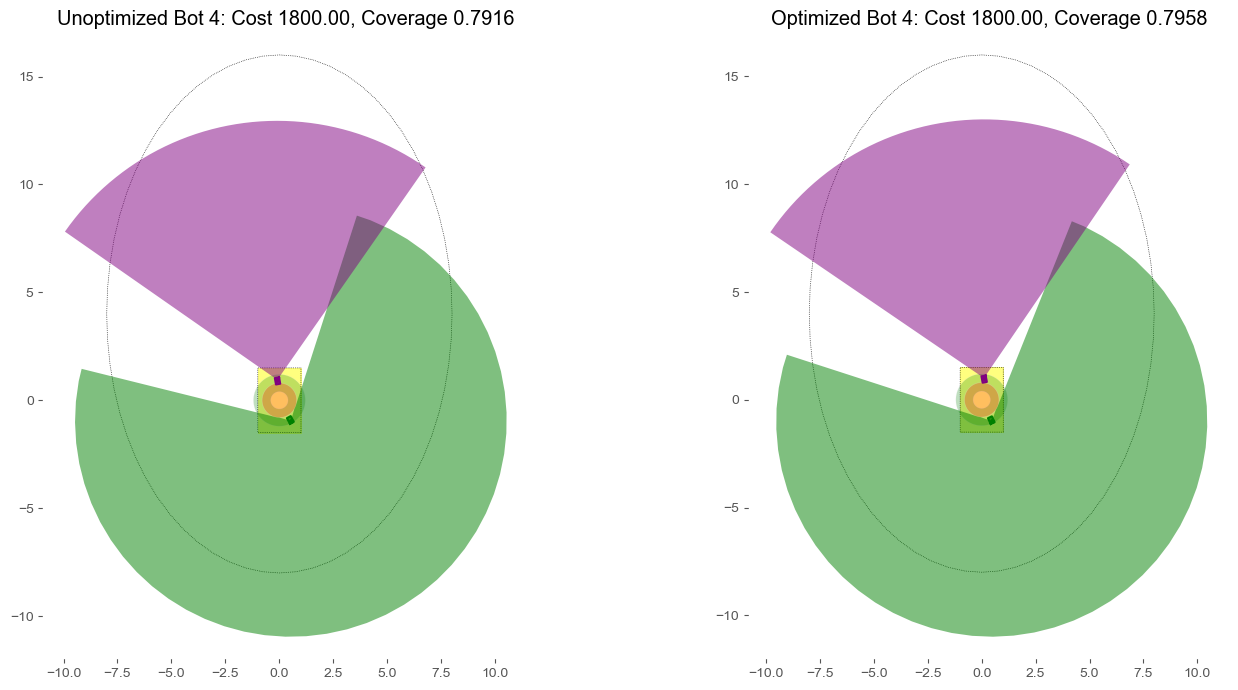

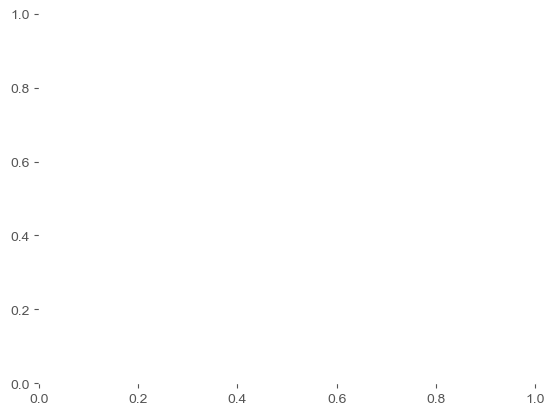

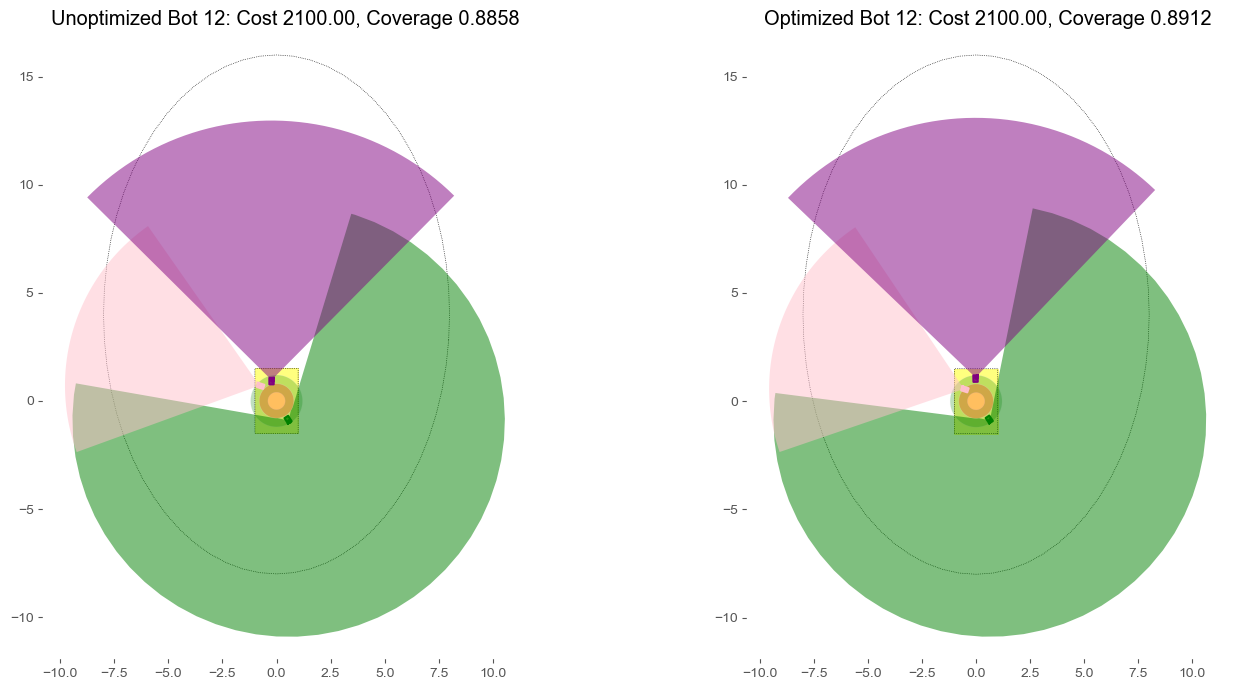

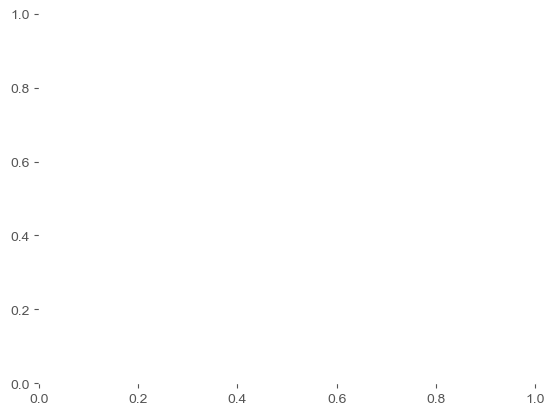

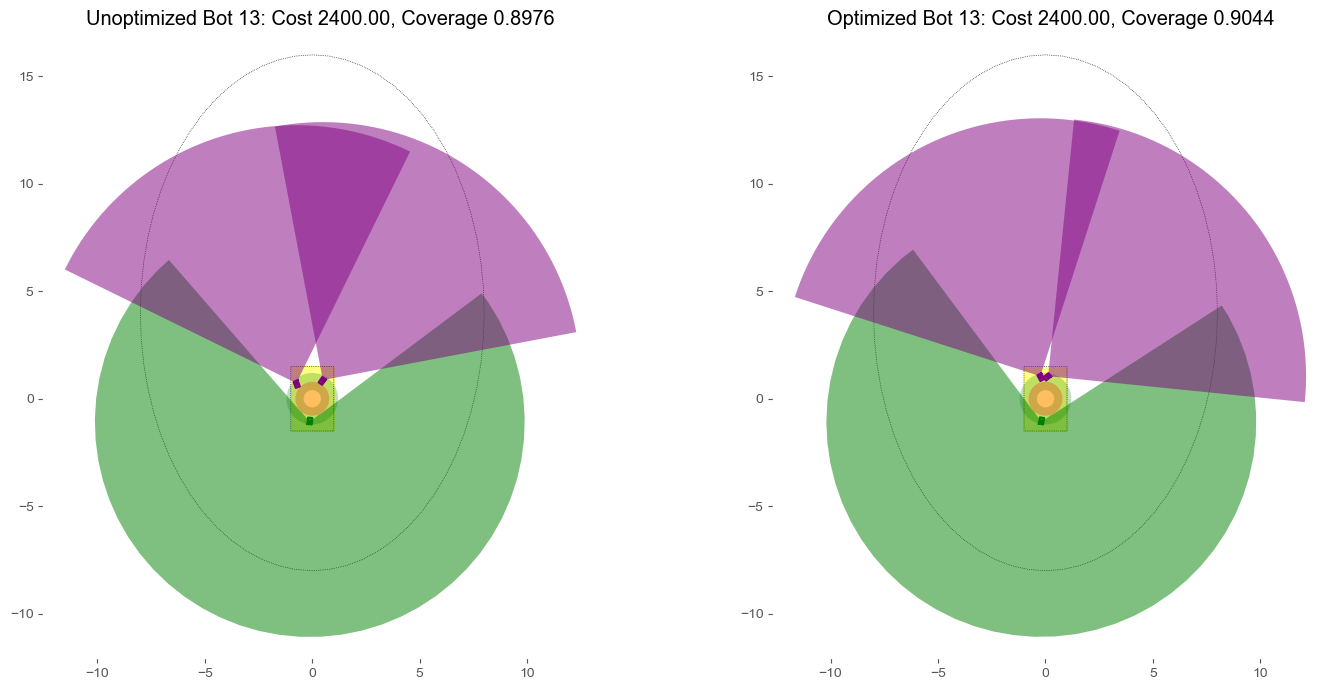

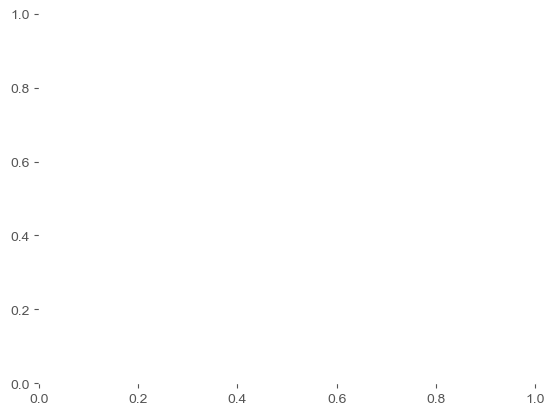

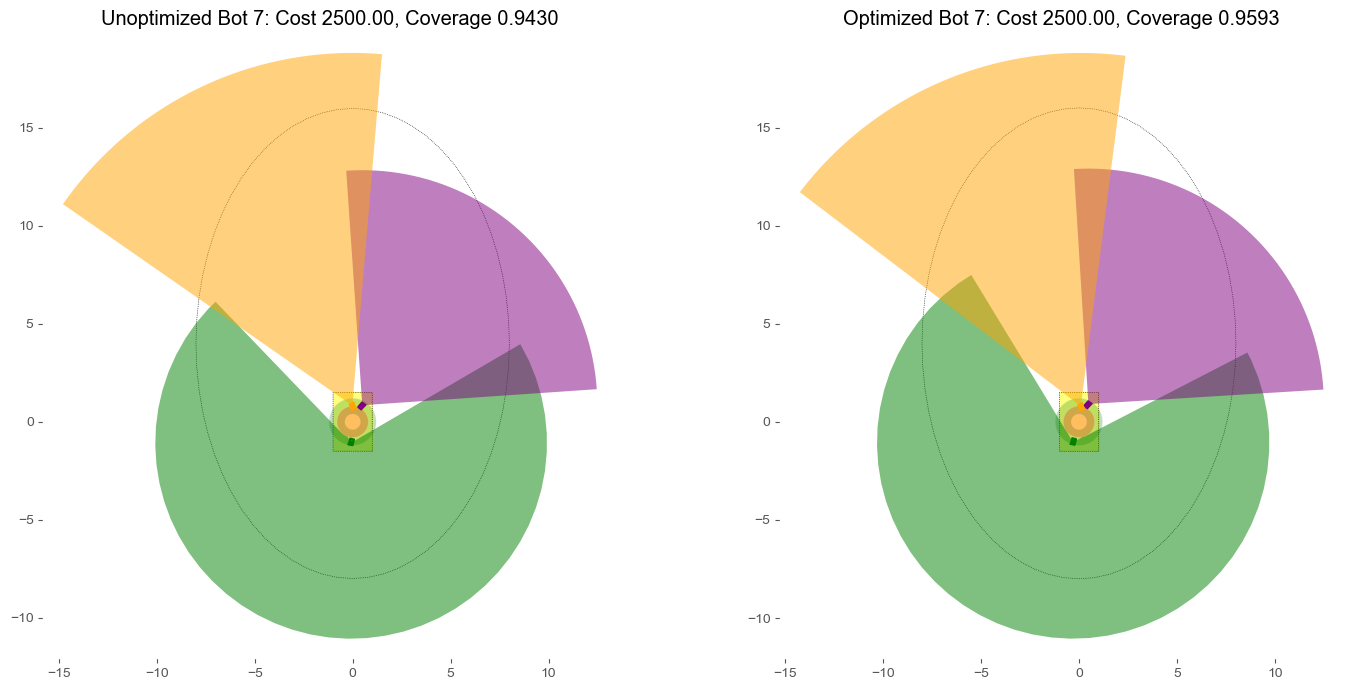

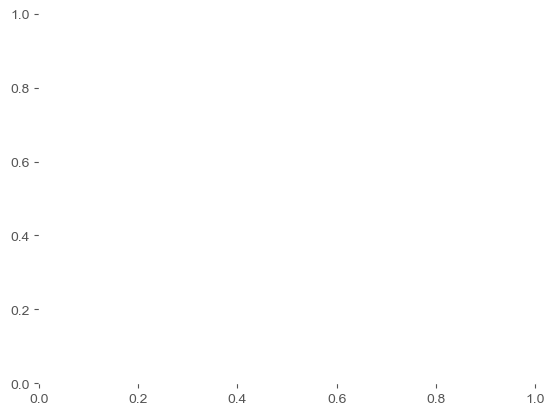

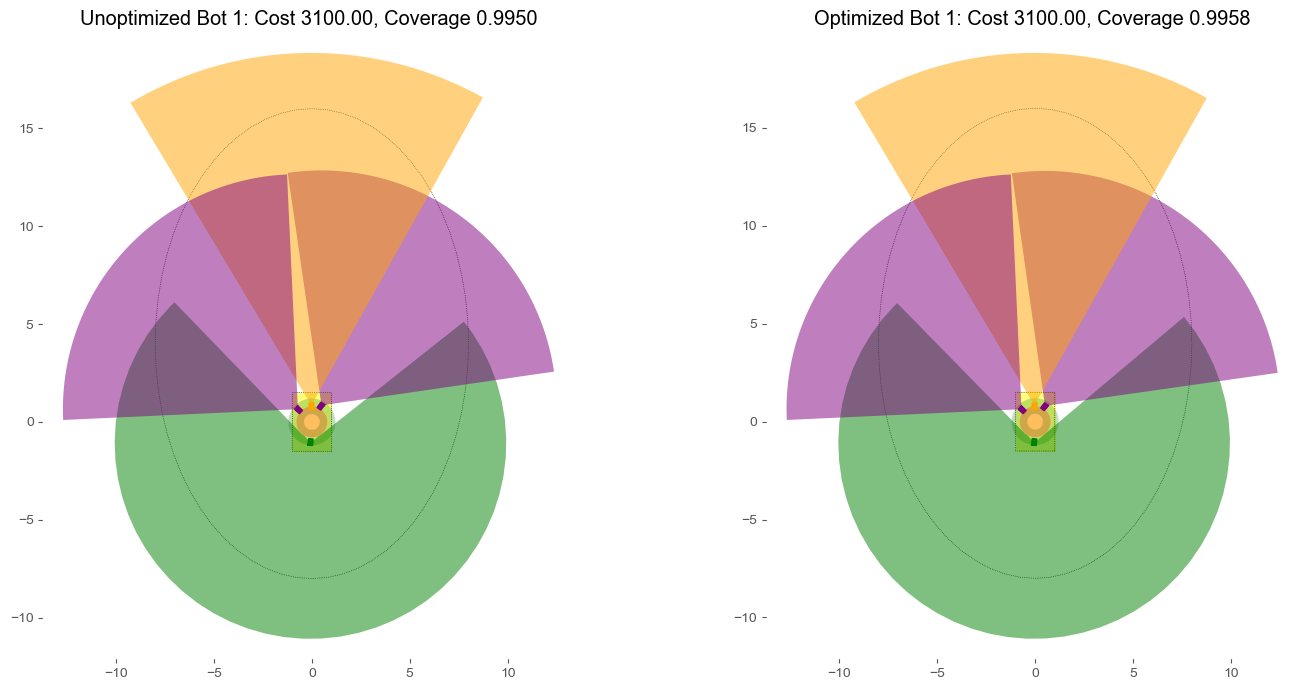

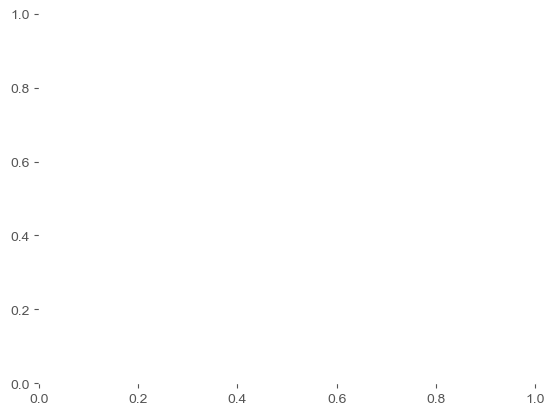

In [11]:
results_optimized = {"X": [], 
                     "F": [],
                     "histories": []}

for idx in tqdm(pareto_idx, leave=True):
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))

    bot = problem.convert_1D_to_bot(res.X[idx])
    bot.plot_bot(show_constraint=True, title=f"Unoptimized Bot {idx}: Cost {res.F[idx, 1]:.2f}, Coverage {1-res.F[idx, 0]:.4f}", ax=axes[0])
    
    bot_optimal = copy.deepcopy(bot)
    if len(bot_optimal.sensors) > 0:
        history = bot_optimal.optimize_sensor_placement(plot=True, plot_title=f"Optimization of Bot {idx}")
    else:
        history = None
        print("No sensors to optimize! Skipping optimization step.")
    bot_optimal.plot_bot(show_constraint=True, title=f"Optimized Bot {idx}: Cost {bot_optimal.get_pkg_cost():.2f}, Coverage {bot_optimal.get_sensor_coverage():.4f}", ax=axes[1])
    
    fig.tight_layout()
    fig.savefig(f"./_output/{bot_name.lower()}/{timestamp}_botcompare_{idx}.png")
    fig.show()
    
    results_optimized["X"].append(problem.convert_bot_to_1D(bot_optimal, verbose=False, dtype=dict))
    results_optimized["F"].append([bot_optimal.get_sensor_coverage(), bot_optimal.get_pkg_cost()])
    results_optimized["histories"].append(history)

In [12]:
pareto_optimized_df = pd.DataFrame(results_optimized['F'], columns=['Perception Coverage', 'Cost'], index=pareto_idx)
pareto_optimized_df['Perception Coverage'] = (pareto_optimized_df['Perception Coverage']) * 100
pareto_optimized_df['Index'] = pareto_unoptimized_df['Index']
pareto_optimized_df['Name'] = [f"Pkg Concept {i}" for i in pareto_optimized_df.index]
pareto_optimized_df['X'] = results_optimized["X"]
pareto_optimized_df['History'] = results_optimized["histories"]
pareto_optimized_df["Optimized"] = "Optimized"

pareto_optimized_df.to_pickle(f"./_output/{bot_name.lower()}/{timestamp}_df_opt.pkl")
pareto_optimized_df

,Perception Coverage,Cost,Index,Name,X,History,Optimized
0,0.000000,0.0,0,Pkg Concept 0,"{'s0_type': 0, 's0_x': 0, 's0_y': 0, 's0_rotat...",None,Optimized
3,17.919369,300.0,3,Pkg Concept 3,"{'s0_type': 4, 's0_x': 0.013645624855186611, '...","{'fun': [-0.17918824443037595, -0.179188244430...",Optimized
8,37.188462,600.0,8,Pkg Concept 8,"{'s0_type': 1, 's0_x': -1.064552741592287, 's0...","{'fun': [-0.37150625079098926, -0.371506250790...",Optimized
9,51.988553,900.0,9,Pkg Concept 9,"{'s0_type': 4, 's0_x': -0.2345904798788343, 's...","{'fun': [-0.5146587733370594, -0.5146587733370...",Optimized
5,65.721427,1200.0,5,Pkg Concept 5,"{'s0_type': 4, 's0_x': -0.17099228347647255, '...","{'fun': [-0.638885104740095, -0.63888510474009...",Optimized
6,72.785501,1500.0,6,Pkg Concept 6,"{'s0_type': 4, 's0_x': -0.9266608901677795, 's...","{'fun': [-0.6987572377849085, -0.6987572377849...",Optimized
4,79.578657,1800.0,4,Pkg Concept 4,"{'s0_type': 2, 's0_x': 0.46450288839032083, 's...","{'fun': [-0.791553132564153, -0.79155313256415...",Optimized
12,89.118356,2100.0,12,Pkg Concept 12,"{'s0_type': 2, 's0_x': 0.6367724053777728, 's0...","{'fun': [-0.8858254824428681, -0.8858254824428...",Optimized
13,90.440951,2400.0,13,Pkg Concept 13,"{'s0_type': 2, 's0_x': -0.1942227282577651, 's...","{'fun': [-0.8976460057300795, -0.8976460057300...",Optimized
7,95.929819,2500.0,7,Pkg Concept 7,"{'s0_type': 2, 's0_x': -0.29514179551125075, '...","{'fun': [-0.9429564762285739, -0.9429564762285...",Optimized


# Introspect with a video

In [ ]:
from IPython.display import HTML

# fig, axes = plt.subplots(1, 2, figsize=(15, 7))
idx = 13

bot = problem.convert_1D_to_bot(res.X[idx])
# bot.plot_bot(show_constraint=True, title=f"Unoptimized Bot {idx}: Cost {res.F[idx, 1]:.2f}, Coverage {1-res.F[idx, 0]:.4f}", ax=axes[0])

bot_optimal = copy.deepcopy(bot)
ani = bot_optimal.optimize_sensor_placement(plot=False, animate=True, anim_interval=50)
HTML(ani.to_jshtml())
ani.save(f"./_artifacts/_optimization_animation.mp4", writer='ffmpeg')

# bot_optimal.plot_bot(show_constraint=True, title=f"Optimized Bot {idx}: Cost {bot_optimal.get_pkg_cost():.2f}, Coverage {bot_optimal.get_sensor_coverage():.4f}", ax=axes[1])

# plt.tight_layout()

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approxima

In [14]:
# Create the scatter plot
pareto_combined_df = pd.concat([pareto_unoptimized_df, pareto_optimized_df], axis=0)
pareto_combined_df


,Perception Coverage,Cost,Index,Name,X,History,Optimized
0,0.000000,0.0,0,Pkg Concept 0,"{'s0_type': 0, 's1_type': 0, 's2_type': 0, 's3...",None,Non-optimized
3,17.918824,300.0,3,Pkg Concept 3,"{'s0_type': 0, 's1_type': 0, 's2_type': 0, 's3...",None,Non-optimized
8,37.150625,600.0,8,Pkg Concept 8,"{'s0_type': 0, 's1_type': 1, 's2_type': 0, 's3...",None,Non-optimized
9,51.465877,900.0,9,Pkg Concept 9,"{'s0_type': 4, 's1_type': 0, 's2_type': 0, 's3...",None,Non-optimized
5,63.888510,1200.0,5,Pkg Concept 5,"{'s0_type': 4, 's1_type': 4, 's2_type': 0, 's3...",None,Non-optimized
6,69.875724,1500.0,6,Pkg Concept 6,"{'s0_type': 0, 's1_type': 4, 's2_type': 0, 's3...",None,Non-optimized
4,79.155313,1800.0,4,Pkg Concept 4,"{'s0_type': 2, 's1_type': 0, 's2_type': 0, 's3...",None,Non-optimized
12,88.582548,2100.0,12,Pkg Concept 12,"{'s0_type': 2, 's1_type': 4, 's2_type': 0, 's3...",None,Non-optimized
13,89.764601,2400.0,13,Pkg Concept 13,"{'s0_type': 2, 's1_type': 1, 's2_type': 0, 's3...",None,Non-optimized
7,94.295648,2500.0,7,Pkg Concept 7,"{'s0_type': 2, 's1_type': 1, 's2_type': 0, 's3...",None,Non-optimized


# Tradespace (Pareto Fronts)

In [15]:
hv_unoptimized = get_hypervolume(pareto_unoptimized_df, [15000, 0], x='Cost', y='Perception Coverage')
hv_combined = get_hypervolume(pareto_combined_df, [15000, 0], x='Cost', y='Perception Coverage')
hv_improvement = hv_combined - hv_unoptimized

print(f"Hypervolume Unoptimized: {hv_unoptimized:.2f}")
print(f"Hypervolume Optimized:   {hv_combined:.2f}")
print(f"Hypervolume Improvement: {hv_improvement:.2f} = +{hv_improvement/hv_unoptimized *100:.2f}%")

fig = plot_tradespace(pareto_combined_df, df_results.shape[0], panzoom=True, width=600, height=450)
fig.show()

Hypervolume Unoptimized: 1372066.78
Hypervolume Optimized:   1375837.16
Hypervolume Improvement: 3770.38 = +0.27%
